## An extensive analysis of the headlines of *The Irish Times* published in 2019
By Davide Castellini (https://github.com/davidecastellini3)

## 1. Data and Preprocessing

### 1.1 Dataset
The dataset used in this project contains the news headlines published by *The Irish Time*, a newspaper operating within Ireland, from 1996 to 2019 and can be downloaded from https://www.kaggle.com/therohk/ireland-historical-news. The dataset has three columns and roughly 1.48 million documents:
1. `publish_date`: date of the article being published in yyyyMMdd format
2. `headline_category`: category of the headline
3. `headline_text`: title of the article in English

### 1.2 Preprocessing
Before moving to any analysis, we need to clean the data: first, given the huge number of headlines available, we decided to restrict our attention only to those published in *2019*. This consists in a significant reduction in the number of documents: the new dataset will have roughly 61,000 instances. This is done in order to reduce the computational time that would be required to preprocess the entire corpus. 

The most important part of our preprocessing process is the lemmatization of the headlines and this has been done using `spacy`: in order to save time, we disabled the analyses we were not interested to. To perform lemmatization, we defined the function `clean` that takes as input a headline and returns its cleaned version. In the lemmatization process, we considered only the POS we were interested in and, in doing so, we removed all punctuations and stop-words present in the headlines. Moreover, we exploited regular expressions, through `re`, to remove numbers from the headlines.


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import time

In [2]:
data = pd.read_csv('ireland-historical-news/ireland-news-headlines.csv')
data.head()

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life


In [3]:
print(data.duplicated().sum())
print('shape:', data.shape)

0
shape: (1484340, 3)


Let us split the *publish_date* column into three columns (year, month, and day of publishing). We will then visualize the number of headlines per year in order to decide which year to use in our analysis.

In [4]:
year = [] 
month = [] 
day = [] 

dates = data.publish_date.values

for date in dates:
    str_date = list(str(date))
    year.append(int(''.join(str_date[0:4]))) 
    month.append(int(''.join(str_date[4:6])))
    day.append(int(''.join(str_date[6:8])))
    
data['year'] = year
data['month'] = month
data['day'] = day

data.drop(['publish_date'] , axis=1,inplace=True) 

In [5]:
data.head()

,headline_category,headline_text,year,month,day
0,news,UUP sees possibility of voting Major out,1996,1,2
1,news,Pubs targeted as curbs on smoking are extended,1996,1,2
2,news,Papers reveal secret links with O'Neill cabinet,1996,1,2
3,news,Domestic chaos as Italy takes EU presidency,1996,1,2
4,news,Learning about the star to which we owe life,1996,1,2


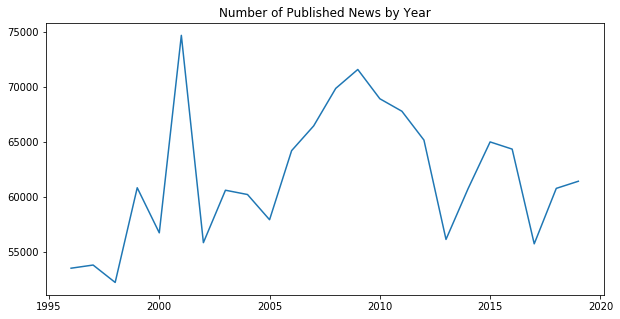

In [6]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x=data.year.value_counts().index.values,y=data.year.value_counts().values)
ax = plt.title('Number of Published News by Year')

To speed up the analysis, we decided to use only the headlines published in 2019 that amount to 61415 documents.

In [7]:
data_19 = data[data.year == 2019]

In [8]:
data_19.shape

(61415, 5)

The function `clean` takes as input the headline (as a string) and returns its preprocessed version (lowercase, lemmatized, and without numbers, punctuations and stop words). We apply it to the column *headline_text* and then we store the preprocessed headlines in a new column, called *headline_cleaned*.

In [9]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def clean(text):
    txt = re.sub('\w*\d\w*', '', text)
    return ' '.join([token.lemma_ 
             for token in nlp(txt) 
             if (token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'} and token.lemma_ != '-PRON-')])


In [10]:
%time data_19['headline_cleaned'] = data_19['headline_text'].apply(clean)

CPU times: user 6min 15s, sys: 5.68 s, total: 6min 20s
Wall time: 3min 50s


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
data_19.shape

(61415, 6)

We also decided to look at the column *headline_category* that contains 92 different categories. However, we reduced this number by considering only the macro categories and we will later use this in topic modelling as the starting number of topics for LDA.

In [12]:
data_19['headline_category'].unique().shape

(92,)

In [13]:
data_19['category_cleaned'] = data_19['headline_category'].apply(lambda x: x.split('.')[0])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
print('Number of macro categories: ',len(set(data_19['category_cleaned'])))
print('Macro categories: ', set(data_19['category_cleaned']))

Number of macro categories:  7
Macro categories:  {'sport', 'removed', 'opinion', 'lifestyle', 'culture', 'news', 'business'}


We also define a function called `statistics` that computes the number of documents, types and tokens in our dataset.

In [15]:
def statistics(df, col):
    docs = len(df)
    
    vocab = [row.split() for row in df[col]]
    vocab = [item for line in vocab for item in line]
    
    types = len(set(vocab))
    
    tokens = len(vocab)
    
    return docs, types, tokens

In [16]:
docs_before, types_before, tokens_before = statistics(data, 'headline_text')
docs_after, types_after, tokens_after = statistics(data_19, 'headline_cleaned')

Here we can see the statistics of our dataset before and after the application of the preprocessing steps.

In [17]:
print(f'The dataset before preprocessing has {docs_before} documents, {types_before} types and {tokens_before} tokens')
print()
print(f'The dataset after preprocessing has {docs_after} documents, {types_after} types and {tokens_after} tokens')

The dataset before preprocessing has 1484340 documents, 301428 types and 10531420 tokens

The dataset after preprocessing has 61415 documents, 26812 types and 449506 tokens


---

In [18]:
df = data_19[data_19['headline_cleaned'].notnull()]

## 2. Analysis

### 2.1 Word Embeddings

We will create dense word embeddings in order to be able to study the semantic and syntactic similarities between words. Using this approach, words will be represented as multidimensional vectors, where each number represents how close are the vectors and thus the words. This will be implemented using `Word2Vec` and some similarity analysis will be carried out to see how the model performs. In section 3.1, a visualization of word similarities using t-SNE is provided.

In [19]:
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION

In [66]:
corpus = [row.split() for row in df['headline_cleaned']]

w2v_model = Word2Vec(size=200, 
                     window=15, 
                     iter=300,
                     negative=5, 
                     min_count=100,
                     workers=-1, 
                     hs=0
)

print('building vocab')
w2v_model.build_vocab(corpus)

print('training model')
%time w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)


building vocab
training model
CPU times: user 17.6 s, sys: 323 ms, total: 17.9 s
Wall time: 18 s


(0, 0)

In [67]:
# Top 10 most similar words to 'government'
w2v_model.wv.most_similar('government')

[('meath', 0.21668754518032074),
 ('crime', 0.18655246496200562),
 ('wrong', 0.1751992553472519),
 ('as', 0.17286467552185059),
 ('blow', 0.17156338691711426),
 ('diary', 0.1654767394065857),
 ('bus', 0.1634271889925003),
 ('industry', 0.162122905254364),
 ('backstop', 0.16065502166748047),
 ('frank', 0.15989843010902405)]

In [68]:
# The similarity between these two words
s1 = w2v_model.wv.similarity(w1='football', w2='rugby')
s2 = w2v_model.wv.similarity(w1='tax', w2='government')
print('Similarity between football and rugby: ', s1)
print('Similarity between tax and government: ', s2)

Similarity between football and rugby:  0.08597906
Similarity between tax and government:  0.06918767


### 2.2 Analysis of important terms

When we look at our corpus, we want to know which are the most important terms used in the headlines. Relying only on term frequency could be misleading since some words occur very often and are not very related to the problem we are analyzing. Therefore, we will weigh the term frequency by its document frequency in order to have more consistent estimates. This will be done using `CountVectorizer` and `TfidfVectorizer`, in which we will consider both unigrams and bigrams. Moreover, we will also apply collocation detection to a our corpus to find out which words are more likely to occur in the context of other words.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.001, max_df=0.7, stop_words='english')
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.001, max_df=0.7, stop_words='english')

X_vect = vectorizer.fit_transform(df['headline_cleaned'])
X_tfidf = tfidf.fit_transform(df['headline_cleaned'])

print(f'CountVectorizer: {X_vect.shape}, TfidfVectorizer: {X_tfidf.shape}')

CountVectorizer: (61415, 1348), TfidfVectorizer: (61415, 1348)


In [24]:
df_tf = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 'tf': X_vect.sum(axis=0).A1})\
                    .sort_values('tf', ascending=False)
df_tf

,word,tf
625,irish,3769
624,ireland,3345
131,brexit,2748
1035,say,2463
811,new,2450
...,...,...
149,buyer,62
800,murray,62
910,presidential,62
254,connor,62


In the table above, we can see the most frequent words in our corpus. Now we will create a new table in which we will weigh the term frequency of a word by its document frequency. The new table will be sorted by TF-IDF, TF and IDF in descending order.

In [25]:
df_terms = pd.DataFrame(data={'word': vectorizer.get_feature_names(),
                             'tf': X_vect.sum(axis=0).A1,
                             'idf': tfidf.idf_,
                             'tfidf': X_tfidf.sum(axis=0).A1})

df_terms = df_terms.sort_values(['tfidf','tf','idf'], ascending=False).reset_index(drop=True)

In [26]:
df_terms

,word,tf,idf,tfidf
0,irish,3769,3.806100,1127.900039
1,ireland,3345,3.921024,1078.199460
2,brexit,2748,4.109348,896.139517
3,dublin,2425,4.234316,838.463634
4,new,2450,4.231427,822.209535
...,...,...,...,...
1343,broadband plan,62,7.882291,29.814336
1344,add time,63,7.866543,29.807133
1345,asylum seeker,63,7.866543,28.950009
1346,dún,62,7.882291,28.655972


We noticed that, even weighing with the document frequency, words with higher term frequency still have very high tf-idf scores and this is because they occur very often in our corpus. However, we are interested in the words that are moderately frequent, but occur in only few documents that are shown below.

In [27]:
mod = df_terms[(df_terms['tf'] > 400) & (df_terms['tf'] < 1100) & 
               (df_terms['idf'] > 3) & (df_terms['idf'] < 7)]
mod

,word,tf,idf,tfidf
12,win,1087,5.039784,430.042757
14,trump,1038,5.082303,416.323952
15,home,988,5.137873,415.062472
16,time,1002,5.119672,414.871443
17,review,821,5.313685,400.853324
...,...,...,...,...
113,rugby,472,5.870568,179.912576
116,world cup,481,5.847482,174.123044
117,gardaí,412,6.001978,173.564652
121,varadkar,401,6.028974,170.098858


### 2.3 Topic modeling

In order to find which are the topics of our headlines, we will use both LDA and matrix factorization (SVD and NMF). \
We will start the topic analysis with LDA since there are some evaluation metrics we can rely on for setting the number of topics. In the initial dataset, together with the news headlines, we also had the category they belonged to: after cleaning them, we found seven main categories, that will be our initial guess for the number of topics. \
Once the optimal numbe rof topics is set, we can proceed with the matrix factorization methods and compare their results with the ones obtained using LDA.

#### 2.3.1 LDA

In [28]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import multiprocessing

In [29]:
df['headline_cleaned'] = df['headline_cleaned'].apply(str)
instances = df['headline_cleaned'].apply(str.split)
print("creating dictionary", flush=True)
dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below=80, no_above=0.2)
print(dictionary, flush=True)

creating dictionary
Dictionary(1068 unique tokens: ['close', 'club', 'old', 'social', 'year']...)


In [30]:
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In order to choose the optimal number of topics, we will fit our LDA model with different number of topics and then evaluate it using the CV coherence model. To correctly evaluate the performance of our model, we divided the corpus into a training set we will use to fit the LDA model and a test set that will be used in the coherence model. We decided to make a 70-30 partition.

In [35]:
coherence_values = []
tops = range(7, 18)

train = int(len(df)*0.7)
test = len(df) - train

for num_topics in tops:
    model = LdaMulticore(corpus=model_corpus[:train], id2word=dictionary, num_topics=num_topics)

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[train:train+test], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    cv_score = coherencemodel_cv.get_coherence()
    
    print(f'num_topics: {num_topics}, score: {cv_score}')
    coherence_values.append(cv_score)

num_topics: 7, score: 0.30425966513773617
num_topics: 8, score: 0.3186884154490519
num_topics: 9, score: 0.3739321491450301
num_topics: 10, score: 0.40553073568558473
num_topics: 11, score: 0.37012195727272545
num_topics: 12, score: 0.389777857686388
num_topics: 13, score: 0.39766654087700637
num_topics: 14, score: 0.40262241670337434
num_topics: 15, score: 0.4000422260067419
num_topics: 16, score: 0.4185698027104839
num_topics: 17, score: 0.461414674855483


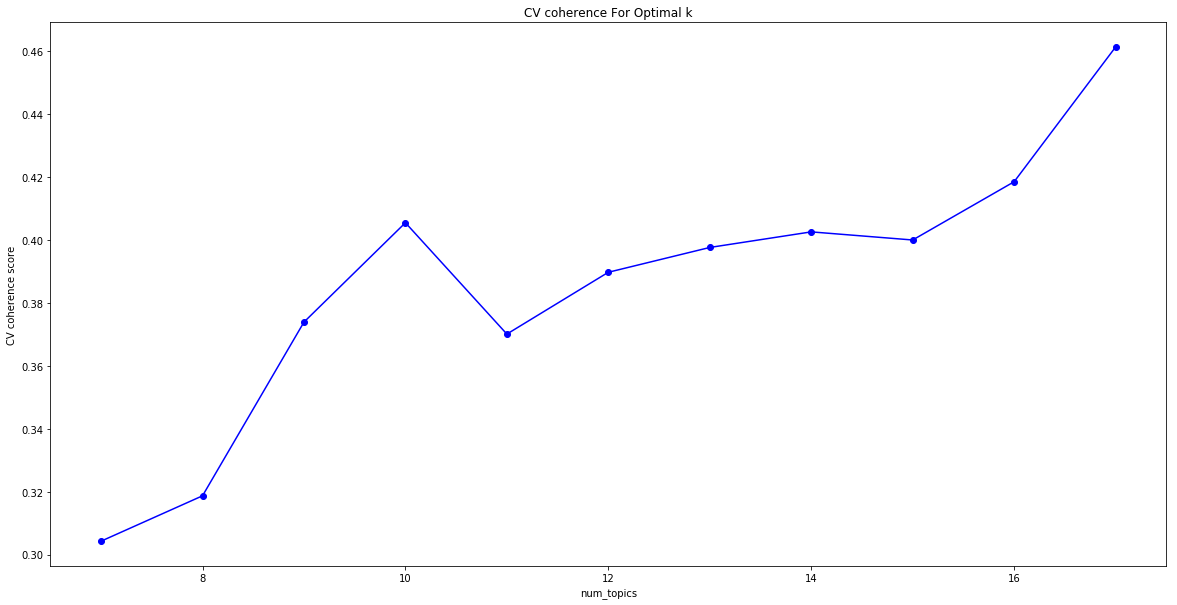

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(tops, coherence_values, 'bo-')
plt.xlabel('num_topics')
plt.ylabel('CV coherence score')
plt.title('CV coherence For Optimal k')
plt.show()

From the CV coherence model, we find that the best number of topics is 14. We will later use this number to find the latent topics using matrix factorization.

In [37]:
num_topics = 17

num_passes = 20
chunk_size = len(model_corpus) * num_passes/200

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus, 
                     id2word=dictionary, 
                     workers=min(10, multiprocessing.cpu_count()-1),
                     passes=num_passes,
                     chunksize=chunk_size,
                     alpha=0.5
                    )
    
print("done in {}".format(time.time()-start), flush=True)


fitting model
done in 149.61716294288635


In [78]:
topic_corpus = model[model_corpus]

topic_sep = re.compile(r"0\.[0-9]{3}\*") 
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print('Topic ', i, ": ", ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

Topic  0 :  "be", "trump", "ireland", "final", "car"
Topic  1 :  "review", "uk", "life", "talk", "that"
Topic  2 :  "court", "tell", "murder", "give", "rule"
Topic  3 :  "people", "why", "should", "work", "award"
Topic  4 :  "get", "call", "case", "open", "lead"
Topic  5 :  "irish", "good", "week", "times", "view"
Topic  6 :  "man", "return", "end", "top", "right"
Topic  7 :  "christmas", "do", "change", "set", "house"
Topic  8 :  "woman", "dublin", "have", "place", "centre"
Topic  9 :  "brexit", "johnson", "eu", "say", "deal"
Topic  10 :  "have", "state", "business", "warn", "group"
Topic  11 :  "day", "leave", "how", "need", "use"
Topic  12 :  "take", "die", "see", "back", "kill"
Topic  13 :  "world", "cup", "rugby", "sell", "co"
Topic  14 :  "new", "chief", "last", "miss", "turn"
Topic  15 :  "what", "be", "show", "school", "old"
Topic  16 :  "death", "bank", "%", "protest", "fall"


#### 2.3.2 Matrix Factorization

In order to compare the topics we will obtain using matrix factorization with those of LDA, we will use the same number of topics, that is the one found with the CV coherence model in LDA.

**Singular Value Decomposition (SVD)**

In [39]:
documents = df['headline_cleaned'].apply(str).tolist()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(61415, 1348)


In [40]:
from sklearn.decomposition import TruncatedSVD 

# set number of latent components equals to the number of topics used in LDA
k = num_topics

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

CPU times: user 861 ms, sys: 51.4 ms, total: 913 ms
Wall time: 466 ms


In [41]:
terms = tfidf_vectorizer.get_feature_names()

We defined the function `display_topics` in order to print the k latent dimensions (topics) obtained using matrix factorization methods.

In [42]:
def display_topics(model, feature_names, no_top_words):
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [43]:
display_topics(svd, terms, 6)


Topic  0
irish, ireland, brexit, times, irish times, view

Topic  1
irish, times, irish times, view, times view, irish woman

Topic  2
brexit, deal, deal brexit, say, uk, johnson

Topic  3
dublin, new, man, year, home, woman

Topic  4
new, year, say, new zealand, zealand, make

Topic  5
man, say, year, woman, make, good

Topic  6
world, good, cup, world cup, make, week

Topic  7
say, trump, dublin, need, change, climate

Topic  8
good, week, year, gig, ireland, week good

Topic  9
year, irish, time, profit, old, jail year

Topic  10
make, irish, home, life, change, review

Topic  11
irish, review, woman, company, people, ireland

Topic  12
review, time, view, child, times, irish times

Topic  13
home, time, trump, court, change, child

Topic  14
woman, home, time, brexit, say, leave

Topic  15
win, time, johnson, boris, boris johnson, week

Topic  16
time, trump, change, climate, woman, new


**Negative Matrix Factorization (NMF)**

In [44]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 5.8 s, sys: 172 ms, total: 5.97 s
Wall time: 3.19 s


In [45]:
display_topics(nmf, terms, 6)


Topic  0
irish, company, people, business, open, water

Topic  1
ireland, northern ireland, northern, player, england, united

Topic  2
brexit, deal, deal brexit, uk, johnson, eu

Topic  3
dublin, buy, city, dublin city, office, house

Topic  4
new, new zealand, zealand, new york, york, look

Topic  5
man, charge, murder, arrest, court, jail

Topic  6
world, cup, world cup, rugby, rugby world, final

Topic  7
say, need, minister, chief, varadkar, eu

Topic  8
good, week, gig, week good, watch, guide

Topic  9
year, jail, old, jail year, profit, year ago

Topic  10
make, happy, work, feel, return, history

Topic  11
times, irish times, view, times view, irish, election

Topic  12
review, life, love, pop, debut, history

Topic  13
home, trump, plan, child, change, climate

Topic  14
woman, die, irish woman, tell, work, court

Topic  15
time, add, add time, return, second, team

Topic  16
win, award, election, claim, prize, title


From the results (topics) we obtained using SVD and NMF, we noticed that NMF's topics are more interpretable than SVD's by looking at the top words for each topic. Moreover, matrix factorization seems to produce better results than those obtained before using LDA. 

We decided to visualize the latent topics obtained with NMF using t-SNE (Section 3.3). We will define the function `nmf_predict` in order to predict the label (topic) of each headline in our dataset. Then, we will fit a t-SNE model with the lower-dimensional matrix W in order to plot the k latent topics (of the matrix W) in two dimensions.

### 2.4 Clustering

We decided to perform clustering using a combination of *Agglomerative Clustering* and *K-Means*. First, we fitted an Agglomerative Clustering on a random subset of our corpus (12,000 documents selected) to find the centroids and then the K-Means algorithm with these centroids. \
We fitted the models using two different input matrices: TF-IDF and Word2Vec. In order to choose the optimal number of clusters, we used the *silhouette score* and choose the number of clusters that had the highest score.

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [47]:
documents = df['headline_cleaned'].apply(str).tolist()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(61415, 1348)


In [48]:
# Clustering with TF-IDF

def clustering(X, limit=12000):
    
    Xc = TruncatedSVD(n_components=300).fit_transform(X)
    sample = np.random.choice(len(Xc), replace=False, size=limit)
    
    K = range(7, 15)
    silhouette = []
    
    for k in K:
        
        agg = AgglomerativeClustering(n_clusters=k)
        agg_labels = agg.fit_predict(Xc[sample,:])
        
        centroids = np.array([Xc[sample,:][agg_labels == c].mean(axis=0) for c in range(k)])
        
        km = KMeans(n_clusters=k, init=centroids)
        km_labels = km.fit_predict(Xc)
        
        score = silhouette_score(Xc, km_labels)
        silhouette.append(score)
        print(f'Clusters: {k}, silhouette: {score}')
        
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(K, silhouette, 'bo-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()

/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 7, silhouette: 0.07605595098052707


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 8, silhouette: 0.07715997555856412


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 9, silhouette: 0.07936073952361905


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 10, silhouette: 0.06669640674384875


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 11, silhouette: 0.06826801627836804


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 12, silhouette: 0.0699232343545383


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 13, silhouette: 0.07106519080526807


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 14, silhouette: 0.07179954402188338


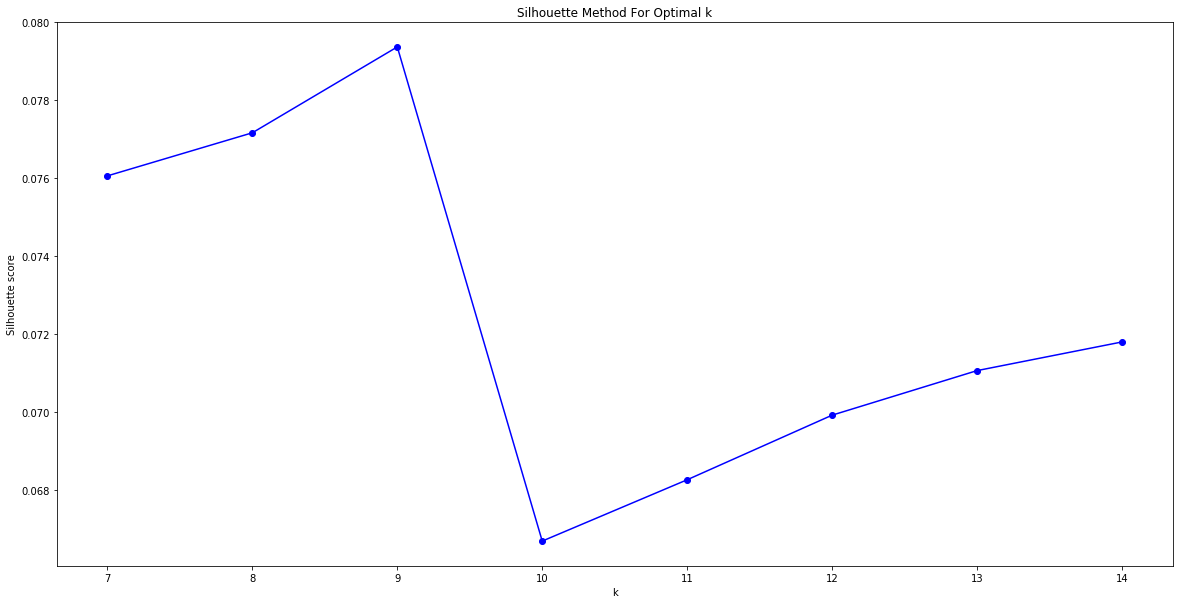

CPU times: user 20min 25s, sys: 1min 36s, total: 22min 2s
Wall time: 16min 5s


In [49]:
%time clustering(X)

/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 7, silhouette: 0.004485243931412697
Clusters: 8, silhouette: 0.0041192397475242615


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 9, silhouette: 0.004251472651958466
Clusters: 10, silhouette: 0.0037113726139068604


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 11, silhouette: 0.004318051040172577
Clusters: 12, silhouette: 0.003905343823134899


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Clusters: 13, silhouette: 0.004049567971378565
Clusters: 14, silhouette: 0.004152233246713877


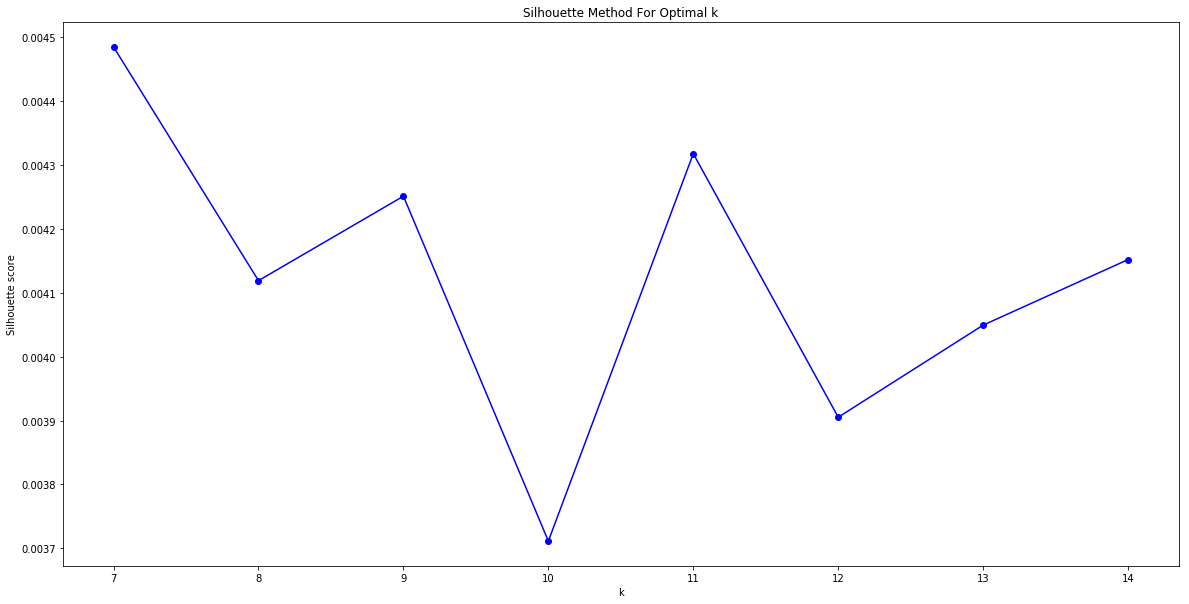

In [71]:
# Clustering with Word2Vec

X_w2v = w2v_model.wv[w2v_model.wv.vocab]

K = range(7, 15)
silhouette = []

for k in K:
    agg = AgglomerativeClustering(n_clusters=k)
    agg_labels = agg.fit_predict(X_w2v)
        
    centroids = np.array([X_w2v[agg_labels == c].mean(axis=0) for c in range(k)])
        
    km = KMeans(n_clusters=k, init=centroids)
    km_labels = km.fit_predict(X_w2v)
        
    score = silhouette_score(X_w2v, km_labels)
    silhouette.append(score)
    print(f'Clusters: {k}, silhouette: {score}')
        
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouette, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

From the above plots of silhouette scores, we noticed that the optimal number of clusters for TF-IDF as input is 9, while for Word2Vec input is 7. In section 3.4, there are visualizations of the results of both clustering.


## 3. Visualization

### 3.1 Word embeddings

In [69]:
from sklearn.manifold import TSNE
from matplotlib import cm

def w2d_similarity(labels):
    
    embedding_clusters = [[w2v_model.wv[similar_word] for similar_word, _ in w2v_model.wv.most_similar(word)] for word in labels]
    word_clusters = [[similar_word for similar_word, _ in w2v_model.wv.most_similar(word)] for word in labels]
    
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    
    tsne = TSNE(n_components=2, perplexity=15, n_iter=3500, init='pca', random_state=32)
    embedding_2d = np.array(tsne.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_2d, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title('Similar words from top five TFIDF')
    plt.show()

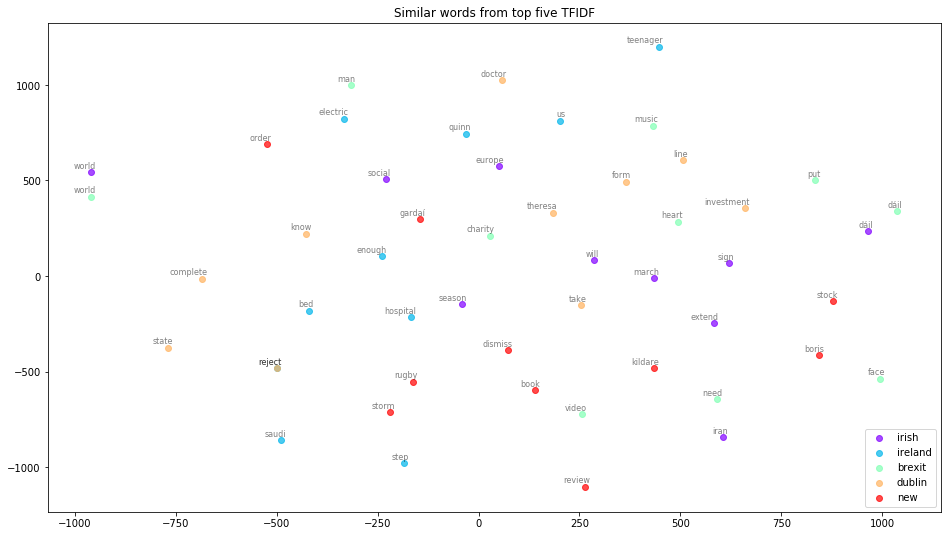

In [70]:
keys = df_terms.word.tolist()[:5]
w2d_similarity(keys)

### 3.2 Analysis of important terms

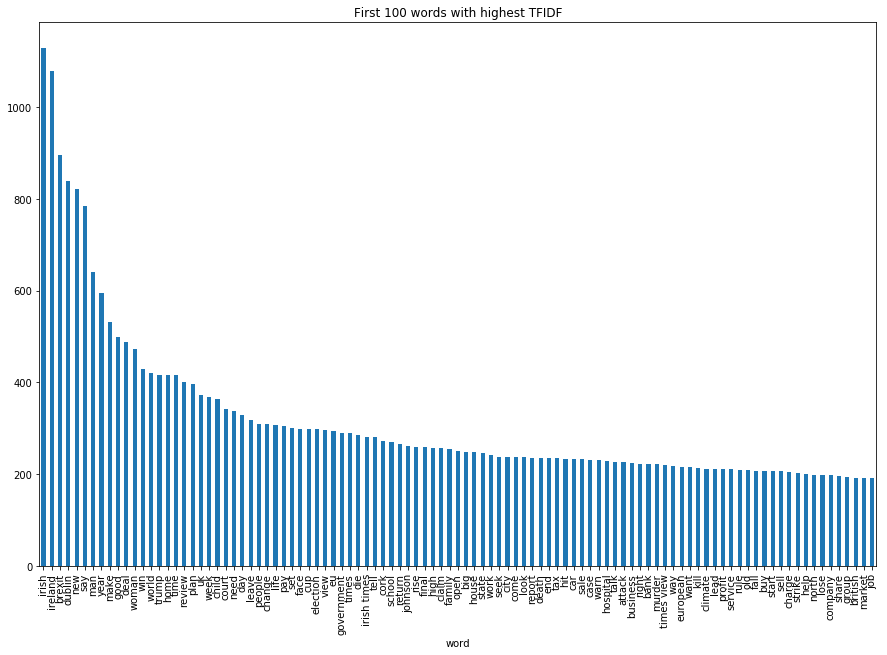

In [53]:
df_terms.loc[:100].plot(x='word', y='tfidf', kind='bar',
                        figsize=(15,10), title='First 100 words with highest TFIDF',
                        legend=False)

### 3.3 Topic modeling

In [56]:
num_topics = 17

topics = [str(topic) for topic in range(num_topics)]

def nmf_predict(vectorizer, model, text):
    text_vect = vectorizer.transform([text])
    result = model.transform(text_vect)
    return topics[np.argmax(result)]

In [57]:
df_labels = df.copy()

labels = [nmf_predict(vectorizer=tfidf_vectorizer, model=nmf, text = row['headline_cleaned']) 
          for index, row in df.iterrows()]
df_labels['label'] = labels

In [74]:
tsne = TSNE(n_components=2, perplexity=40, init='pca', n_iter=300)
%time tsne_tm_results = tsne.fit_transform(W)

CPU times: user 9min 11s, sys: 11.5 s, total: 9min 23s
Wall time: 8min 44s


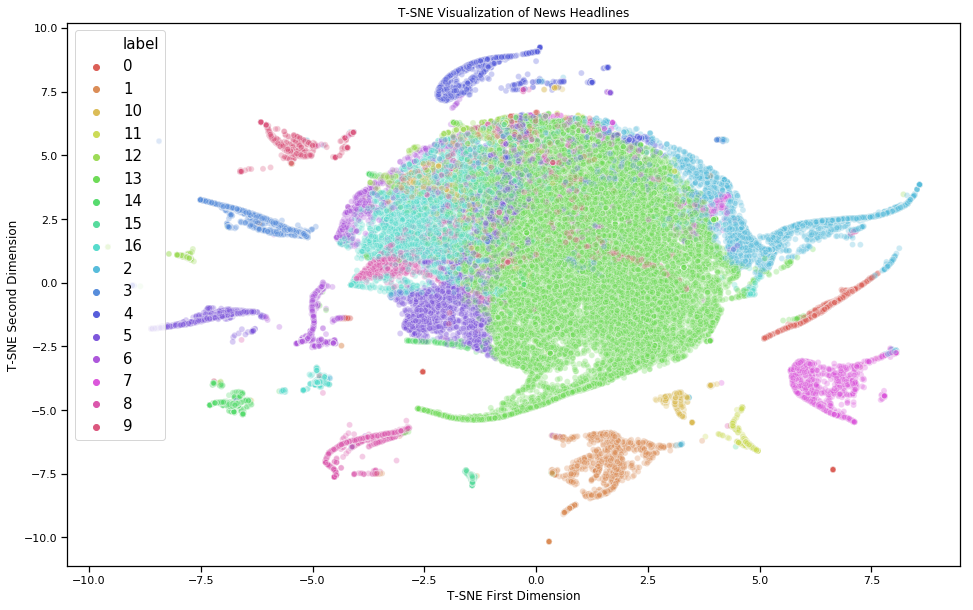

In [75]:
df_labels['tsne_2d_one'] = tsne_tm_results[:,0]
df_labels['tsne_2d_two'] = tsne_tm_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x = 'tsne_2d_one', y = 'tsne_2d_two',
    hue = "label",
    palette = sns.color_palette('hls', num_topics),
    data = df_labels,
    legend = 'full',
    alpha = 0.3
)
plt.xlabel('T-SNE First Dimension')
plt.ylabel('T-SNE Second Dimension')
plt.title('T-SNE Visualization of News Headlines')
plt.legend(loc=2, prop={'size': 15})

We notice that most of the topics are concentrated at the center forming this largest "blob" and this means that these topics are not well separated from one another, even if they have some areas where they are distinct. However, a large part of the "blob" is taken by the green-ish topics (12 to 15), meaning that, even if different, they share some features. We can also notice topics (1, 7, 9, 4) that have strong separation.

### 3.4 Clustering

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('seismic') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend()
    plt.show()

fitting agglomerative clustering
fitting k-means


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


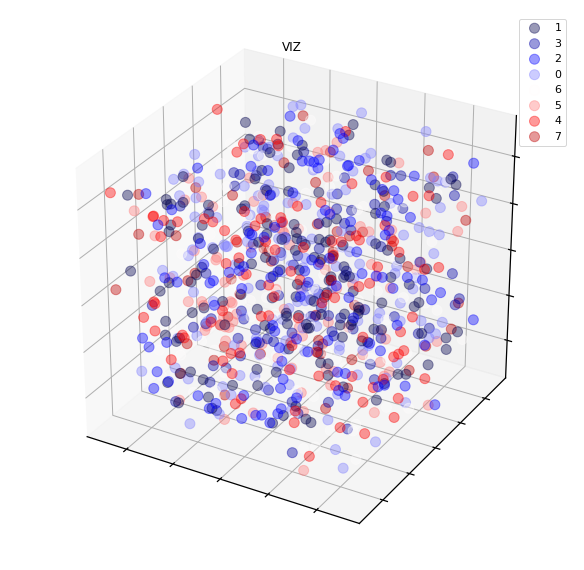

In [73]:
# Clustering with Word2Vec as input
k = 8

agg = AgglomerativeClustering(n_clusters=k)
print('fitting agglomerative clustering')
agg_lab = agg.fit_predict(X_w2v)
centroids = np.array([X_w2v[agg_lab == c].mean(axis=0) for c in range(k)])
    
km = KMeans(n_clusters=k, init=centroids, n_jobs=-1)
print('fitting k-means')
km.fit(X_w2v)

plot_vectors(X_w2v, labels=km.labels_, dimensions=3)

In [76]:
def clustering_viz(X, k, limit=15000, dimensions=2):
    Xc = TruncatedSVD(n_components=300).fit_transform(X)
    sample = np.random.choice(len(Xc), replace=False, size=limit)
    
    agg = AgglomerativeClustering(n_clusters=k)
    print('fitting agglomerative clustering')
    agg_lab = agg.fit_predict(Xc[sample])
    centroids = np.array([Xc[sample][agg_lab == c].mean(axis=0) for c in range(k)])
    
    km = KMeans(n_clusters=k, init=centroids, n_jobs=-1)
    print('fitting k-means')
    km.fit(Xc)
    
    plot_vectors(Xc[sample], labels=km.labels_[sample], dimensions=dimensions)

fitting agglomerative clustering
fitting k-means


/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


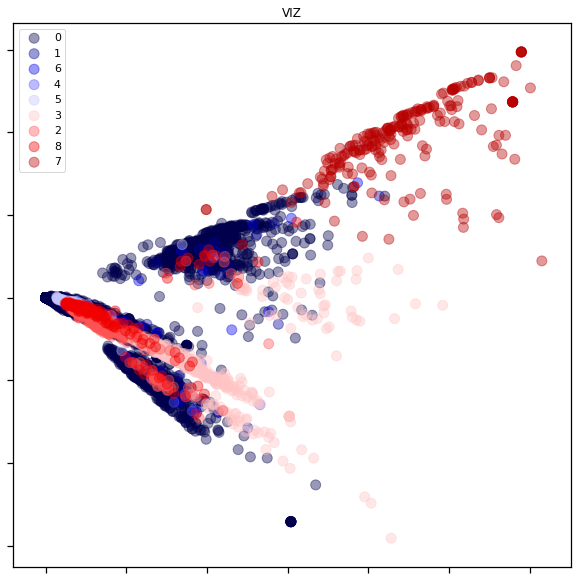

In [77]:
# Clustering with TF-IDF as input
clustering_viz(X, k=9, limit=15000, dimensions=2)

By looking at the first plot (Word2Vec as input), we do not see any separation between the clusters and everything looks very confused, while in the second plot (TF-IDF as input), we can notice a stronger adn clearer separation between the clusters, even if some noise is still present. We should also point out that in the first case we have 8 clusters, while in the second case we found 9.